The below is lightly adapted from [Sasank Chilamkurthy](https://chsasank.github.io)'s [transfer learning tutorial for PyTorch](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html), which is distributed under a BSD License.

# Basic Idea for this Notebook
- A toy example of finetuning a model on some local data. 
- Demo how Workbench gives immediate access to an availabe GPU.
- Can be used on a machine with no GPU, and in that case will show the speedup gained on a GPU after a "laptop-to-cloud" transfer. 
- Accompanying notebook, `run_classifier.ipynb` evaluates the model on some hold out data. 
- Setup is finetuning a model to discriminate between **ants** and **bees**. We have about 120 training images each for ants and bees, with 75 validation images for each class. 

### First import some libraries and functions

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy (edits by Dav Clark, Gigantum)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import os
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from tlt_utilities import tlt_imshow, train_model

### Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

This dataset is a very small subset of imagenet.

There are two high-level folders, `train` and `val`. Both should be in the Project `data` folder that is visible in this JupyterLab instance. 

Note: You can also see it all in your file system as well.

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Here we make our notebook GPU / CPU agnostic
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Check for GPU

This is to temper expectations on how long the training will take. On CPU it will be quite slow, up to 25 minutes. GPU will be much faster, probably less than a minute.


In [3]:
# gtm:ignore
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU unavailable. Using CPU.")

GPU is available


### Visualize a few images

Let's look at some example data to understand what we are trying to do and the data augmentations.



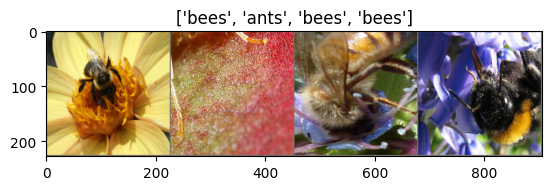

In [4]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

tlt_imshow(out, title=[class_names[x] for x in classes])

### Training the model
------------------

There's a general function to train a model in `tlt_utilities.train_model`. It illustrates:

-  Scheduling the learning rate
-  Saving the best model

Parameter ``scheduler`` is an LR scheduler object from ``torch.optim.lr_scheduler``.



#### First we download the pretrained model and reset  the final fully connected layer. 
----------------------


In [5]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/workbench/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:03<00:00, 13.7MB/s]


## Retrain the model and then save it for later.
It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [6]:
retrained_model_ft = train_model(model_ft, dataloaders, dataset_sizes, criterion, 
                       optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5267 Acc: 0.7102
val Loss: 0.3054 Acc: 0.8627

Epoch 1/24
----------
train Loss: 0.4801 Acc: 0.7959
val Loss: 0.4832 Acc: 0.8562

Epoch 2/24
----------
train Loss: 0.6731 Acc: 0.7755
val Loss: 0.4546 Acc: 0.8301

Epoch 3/24
----------
train Loss: 0.7311 Acc: 0.7469
val Loss: 0.5031 Acc: 0.8105

Epoch 4/24
----------
train Loss: 0.8997 Acc: 0.6816
val Loss: 0.5775 Acc: 0.7974

Epoch 5/24
----------
train Loss: 0.4701 Acc: 0.7796
val Loss: 0.7241 Acc: 0.8039

Epoch 6/24
----------
train Loss: 0.6444 Acc: 0.7755
val Loss: 0.3291 Acc: 0.8693

Epoch 7/24
----------
train Loss: 0.3597 Acc: 0.8653
val Loss: 0.3106 Acc: 0.8693

Epoch 8/24
----------
train Loss: 0.3275 Acc: 0.8571
val Loss: 0.2874 Acc: 0.8954

Epoch 9/24
----------
train Loss: 0.3554 Acc: 0.8286
val Loss: 0.3133 Acc: 0.8758

Epoch 10/24
----------
train Loss: 0.3026 Acc: 0.8735
val Loss: 0.2411 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.2899 Acc: 0.8776
val Loss: 0.2413 Acc: 0.9150

Ep

### Let's save the original model and the retrained model for later comparisons.

In [7]:
# Let's save the model so others can skip the above steps:
torch.save(model_ft, '../models/original.pt')
torch.save(retrained_model_ft, '../models/ants-bees.pt')